**Import Required Libraries**

In [80]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

#Text Preprocessing libraries
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

#ML Model Building Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Model Evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Task 2 - Loading Data set, EDA and initial data visualization**

In [82]:
df=pd.read_csv('/content/drive/MyDrive/Master/NLP/Project2/updated/Corona_NLP_train.csv',encoding='latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


**Data Set Shape**

In [83]:
df.shape

(41157, 6)

**EDA**

In [84]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))

    print("==================================================")

    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))

    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])

    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])

    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))

    print("==================================================")
    print("\nDescription of numerical variables")

    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))

    print("==================================================")
    print("\nDescription of categorical variables")

    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))

    return

In [85]:
basic_eda(df)

Info : There are 6 columns in the dataset
Info : There are 41157 rows in the dataset

Data type information of different columns
Info : There are 4 categorical columns
Info : There are 2 numerical columns
Categorical columns :  ['Location', 'TweetAt', 'OriginalTweet', 'Sentiment']
Numerical columns :  ['UserName', 'ScreenName']


,column_name,dtype
0,UserName,int64
1,ScreenName,int64
2,Location,object
3,TweetAt,object
4,OriginalTweet,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,UserName,41157.0,24377.0,11881.146851,3799.0,14088.0,24377.0,34666.0,44955.0
1,ScreenName,41157.0,69329.0,11881.146851,48751.0,59040.0,69329.0,79618.0,89907.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Location,32567,12220,London,540
1,TweetAt,41157,30,20-03-2020,3448
2,OriginalTweet,41157,41157,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
3,Sentiment,41157,5,Positive,11422


**Initial Data Visualization**

In [86]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

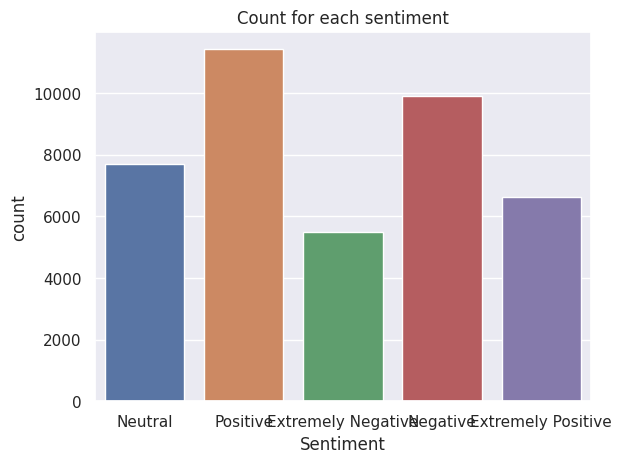

In [87]:
sns.countplot(x=df['Sentiment'])
plt.title("Count for each sentiment")
plt.show()

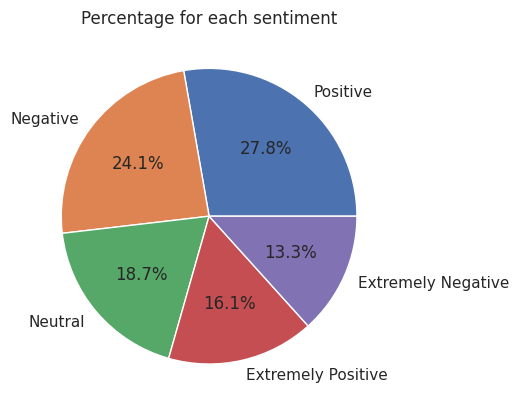

In [88]:
sns.set(style="darkgrid")
sentiment_counts = df['Sentiment'].value_counts(normalize=True) * 100
plt.pie(sentiment_counts, labels = sentiment_counts.index, autopct='%1.1f%%')
plt.title("Percentage for each sentiment")
plt.show()

# **Task 3 - Text Preprocessing**

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


**As I have to do only sentiment analysis, so I only need two columns. I will drop rest of the columns.**

In [90]:
df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)

In [91]:
#Check for nulls
df.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [92]:
#Check for duplicates
df.duplicated().sum()

0

In [93]:

df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


**Now I will classify the sentiments in only 2 categories.**

In [94]:
def categorize_sentiment(score):
    if score == 'Negative':
        return "Negative"
    elif score == 'Extremely Negative':
        return "Negative"
    elif score == 'Positive':
        return "Positive"
    elif score == 'Extremely Positive':
        return "Positive"
    else:
        return "Negative"

In [95]:
df['Sentiment'] = df['Sentiment'].apply(categorize_sentiment)
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Negative
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative


**The 2 categories Visualization**

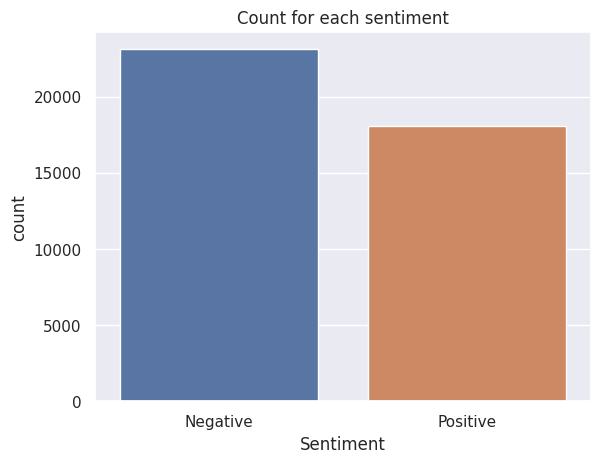

In [96]:
sns.countplot(x=df['Sentiment'])
plt.title("Count for each sentiment")
plt.show()

**Text Preprocessing**

In [97]:
#Let's make a function to preprocess the text
import nltk
nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

def clean_text(text):
    text = text.lower().split()

    #Remove punctuations
    text = [word.translate(str.maketrans('', '', string.punctuation)) for word in text]

    #Remove Stopwords
    text = [word for word in text if word not in stop_words]

    #Stemming
    text = [stemmer.stem(word) for word in text]

    #Joining the text
    joined = ' '.join(text)
    return joined

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
df = df[:1000]
df['text'] = df['OriginalTweet'].apply(clean_text)
df.head()

,OriginalTweet,Sentiment,text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Negative,menyrbi philgahan chrisitv httpstcoifz9fan2pa ...
1,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,Positive,food stock one empti pleas dont panic enough f...
4,"Me, ready to go at supermarket during the #COV...",Negative,readi go supermarket covid19 outbreak im paran...


**Word Cloud**

In [99]:
pip install wordcloud

In [100]:
all_words = ' '.join(word for word in df['text'])

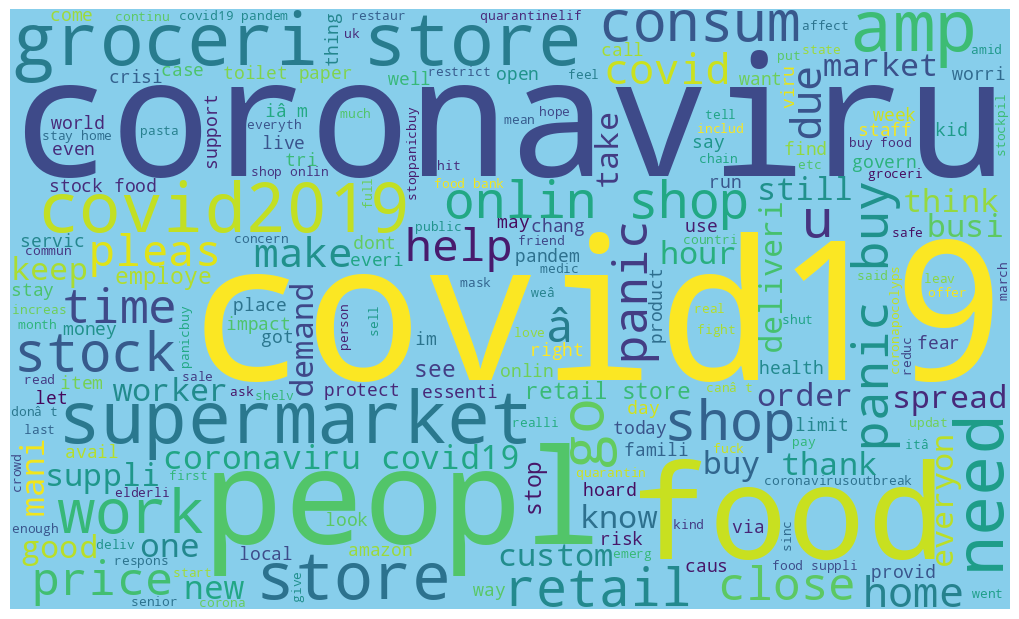

In [101]:
wordcloud = WordCloud(
    width = 1000,
    height = 600,
    background_color = 'skyblue',
    min_font_size = 10).generate(all_words)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# **Task 4 – Text Representation**

**POS Tagging**

In [102]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [103]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# convert text into word_tokens with their tags
def pos_tagging(text):
	word_tokens = word_tokenize(text)
	return pos_tag(word_tokens)

document= " ".join(df["text"])
pos_tagging(document)

[('menyrbi', 'NN'),
 ('philgahan', 'NN'),
 ('chrisitv', 'NN'),
 ('httpstcoifz9fan2pa', 'NN'),
 ('httpstcoxx6ghgfzcc', 'NN'),
 ('httpstcoi2nlzdxno8', 'NN'),
 ('advic', 'JJ'),
 ('talk', 'NN'),
 ('neighbour', 'IN'),
 ('famili', 'NN'),
 ('exchang', 'NN'),
 ('phone', 'NN'),
 ('number', 'NN'),
 ('creat', 'NN'),
 ('contact', 'JJ'),
 ('list', 'NN'),
 ('phone', 'NN'),
 ('number', 'NN'),
 ('neighbour', 'JJ'),
 ('school', 'NN'),
 ('employ', 'VBP'),
 ('chemist', 'NN'),
 ('gp', 'NN'),
 ('set', 'VBN'),
 ('onlin', 'RP'),
 ('shop', 'NN'),
 ('account', 'NN'),
 ('poss', 'NN'),
 ('adequ', 'NN'),
 ('suppli', 'NN'),
 ('regular', 'NN'),
 ('med', 'VBD'),
 ('order', 'NN'),
 ('coronaviru', 'NN'),
 ('australia', 'VBD'),
 ('woolworth', 'JJ'),
 ('give', 'JJ'),
 ('elderli', 'NN'),
 ('disabl', 'NN'),
 ('dedic', 'NN'),
 ('shop', 'NN'),
 ('hour', 'NN'),
 ('amid', 'IN'),
 ('covid19', 'JJ'),
 ('outbreak', 'NN'),
 ('httpstcobinca9vp8p', 'NN'),
 ('food', 'NN'),
 ('stock', 'NN'),
 ('one', 'CD'),
 ('empti', 'NN'),
 ('pleas

**Cosine Similarity**

In [104]:
import numpy as np

def cosine_similarity(x, y):

    # Ensure length of x and y are the same
    if len(x) != len(y) :
        return None
    else:
    # Compute the dot product between x and y
      dot_product = np.dot(x, y)

    # Compute the L2 norms (magnitudes) of x and y
      magnitude_x = np.sqrt(np.sum(x**2))
      magnitude_y = np.sqrt(np.sum(y**2))

    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)

    return cosine_similarity

In [105]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["text"])


In [106]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_1_2 = cosine_similarity(X.getrow(0), X.getrow(1))
cos_sim_1_3 = cosine_similarity(X.getrow(0), X.getrow(2))
cos_sim_2_3 = cosine_similarity(X.getrow(1), X.getrow(2))

print('Cosine Similarity between:')
print('\tDocument 1 and Document 2:', cos_sim_1_2)
print('\tDocument 1 and Document 3:', cos_sim_1_3)
print('\tDocument 2 and Document 3:', cos_sim_2_3)

Cosine Similarity between:
	Document 1 and Document 2: [[0.]]
	Document 1 and Document 3: [[0.]]
	Document 2 and Document 3: [[0.04828045]]


**Word2vec**

In [107]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [108]:
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [109]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [110]:
sentences = [[tok.text for tok in nlp(row)] for row in tqdm(df["text"])]

100%|██████████| 1000/1000 [00:16<00:00, 59.78it/s]


In [111]:
model = gensim.models.Word2Vec(sentences, min_count = 1, vector_size = 100, window = 5)

In [112]:
model.wv.similarity('virus', 'corona')

0.25841334

In [113]:
model.wv.most_similar('virus', topn=10)

[('100000', 0.39127880334854126),
 ('pickup', 0.3772350549697876),
 ('return', 0.37485602498054504),
 ('raw', 0.37481024861335754),
 ('children', 0.3738054633140564),
 ('energi', 0.3724808692932129),
 ('canâ\x92t', 0.36885061860084534),
 ('buyer', 0.368661105632782),
 ('hungri', 0.3645276725292206),
 ('soar', 0.35844725370407104)]

In [114]:
model.wv.most_similar('lockdown', topn=10)

[('home', 0.921994149684906),
 ('us', 0.917965829372406),
 ('suppli', 0.9173396825790405),
 ('get', 0.915720522403717),
 ('tell', 0.9155095815658569),
 ('amp', 0.9149031639099121),
 ('peopl', 0.9148663282394409),
 ('stock', 0.9148194789886475),
 ('supermarket', 0.9144884943962097),
 ('price', 0.913968563079834)]

In [115]:
a = model.wv['lockdown'].reshape(1,-1)
b = model.wv['fear'].reshape(1,-1)

In [116]:
a

array([[-0.01334648,  0.01293831,  0.01497127,  0.00479792,  0.0085624 ,
        -0.02976038,  0.00530198,  0.03384963, -0.00201643, -0.00332835,
        -0.01419284, -0.03356962, -0.00958356,  0.00912999,  0.00784219,
        -0.0147979 , -0.00541215, -0.01750105, -0.00293127, -0.02348854,
         0.01171135,  0.00425653,  0.0162493 , -0.00856071, -0.0134266 ,
        -0.00714657, -0.01684705,  0.00076632, -0.01942884,  0.0087498 ,
         0.0207898 ,  0.00247428,  0.00164646, -0.01411153, -0.01632436,
         0.01414434,  0.00540644, -0.00974451, -0.01667973, -0.03616789,
         0.01110709, -0.01463543, -0.00960748, -0.00058477,  0.01305821,
        -0.00487604, -0.00847906, -0.0093684 ,  0.01444342,  0.01420276,
         0.00063789, -0.0218746 , -0.0098608 , -0.00973442, -0.01100855,
         0.00363076,  0.01971969,  0.0066254 , -0.02216922,  0.00255615,
         0.00205688, -0.00200952,  0.00648989,  0.00621015, -0.01739972,
         0.01630204, -0.0005941 ,  0.01915076, -0.0

In [117]:
cosine_similarity(a, b)

array([[0.8838581]], dtype=float32)

**NGram- Unigram**

In [118]:
from collections import defaultdict

In [119]:
#method to generate n-grams:
#params:
#text-the text for which we have to generate n-grams
#ngram-number of grams to be generated from the text(1,2,3,4 etc., default value=1)


def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]
  print("Sentence after removing stopwords:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [120]:
positiveValues=defaultdict(int)
negativeValues=defaultdict(int)

In [121]:
#get the count of every word in the dataframe where sentiment="positive"
for textt in df[df.Sentiment=="Positive"].text:
  for word in generate_N_grams(textt):
    positiveValues[word]+=1

#get the count of every word in the dataframe where sentiment="negative"
for textt in df[df.Sentiment=="Negative"].text:
  for word in generate_N_grams(textt):
    negativeValues[word]+=1



Sentence after removing stopwords: ['advic', 'talk', 'neighbour', 'famili', 'exchang', 'phone', 'number', 'creat', 'contact', 'list', 'phone', 'number', 'neighbour', 'school', 'employ', 'chemist', 'gp', 'set', 'onlin', 'shop', 'account', 'poss', 'adequ', 'suppli', 'regular', 'med', 'order']
Sentence after removing stopwords: ['coronaviru', 'australia', 'woolworth', 'give', 'elderli', 'disabl', 'dedic', 'shop', 'hour', 'amid', 'covid19', 'outbreak', 'httpstcobinca9vp8p']
Sentence after removing stopwords: ['food', 'stock', 'one', 'empti', 'pleas', 'dont', 'panic', 'enough', 'food', 'everyon', 'take', 'need', 'stay', 'calm', 'stay', 'safe', 'covid19fr', 'covid19', 'covid19', 'coronaviru', 'confin', 'confinementot', 'confinementgener', 'httpstcozrlg0z520j']
Sentence after removing stopwords: ['news', 'regionâ\x92', 'first', 'confirm', 'covid19', 'case', 'came', 'sullivan', 'counti', 'last', 'week', 'peopl', 'flock', 'area', 'store', 'purchas', 'clean', 'suppli', 'hand', 'sanit', 'food', '

In [122]:
#focus on more frequently occuring words for every sentiment=>
#sort in DO wrt 2nd column in each of positiveValues and negativeValues

df_positive=pd.DataFrame(sorted(positiveValues.items(),key=lambda x:x[1],reverse=True))
df_negative=pd.DataFrame(sorted(negativeValues.items(),key=lambda x:x[1],reverse=True))


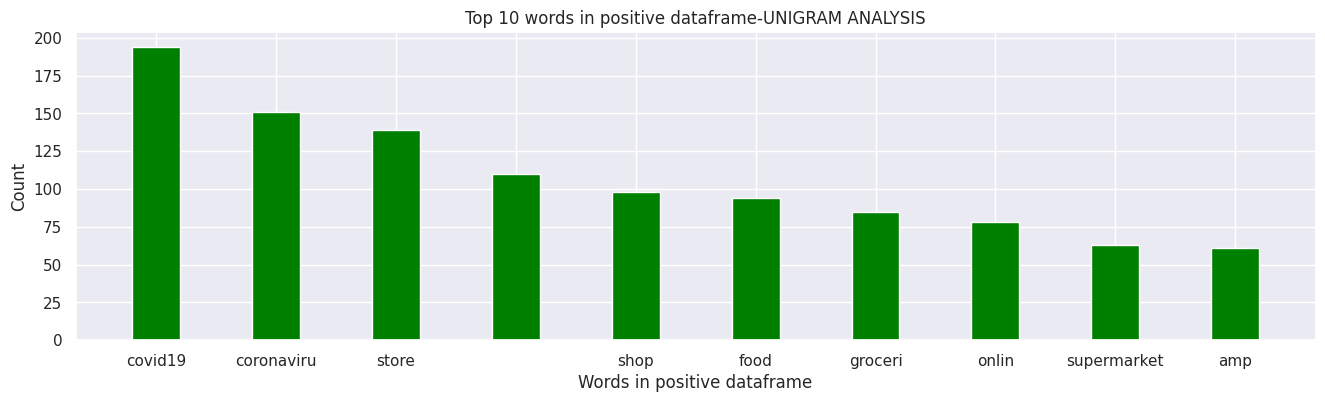

In [123]:
pd1=df_positive[0][:10]
pd2=df_positive[1][:10]

ned1=df_negative[0][:10]
ned2=df_negative[1][:10]



plt.figure(1,figsize=(16,4))

plt.bar(pd1,pd2, color ='green',
        width = 0.4)

plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-UNIGRAM ANALYSIS")

plt.savefig("positive-unigram.png")
plt.show()

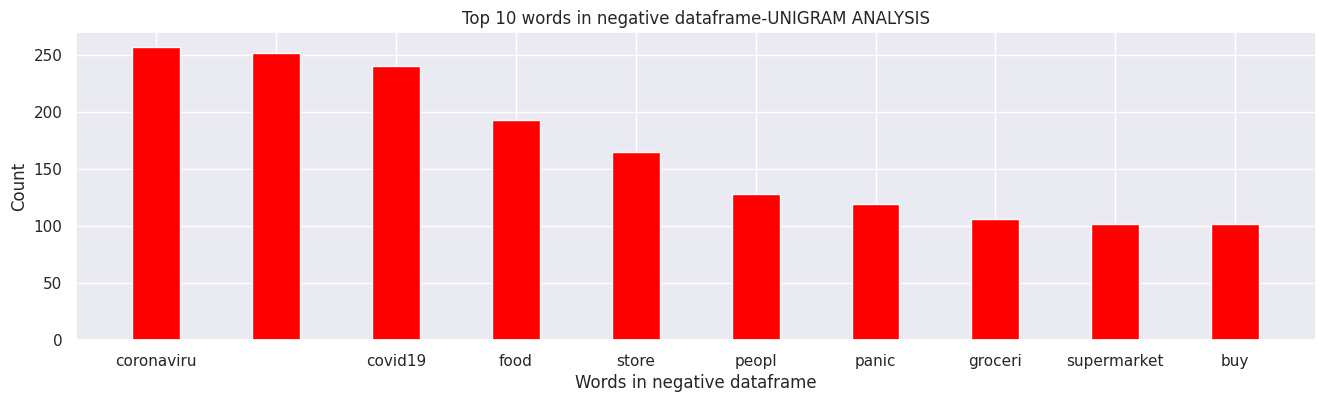

In [124]:
plt.figure(1,figsize=(16,4))

plt.bar(ned1,ned2, color ='red',
        width = 0.4)

plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-UNIGRAM ANALYSIS")

plt.savefig("negative-unigram.png")
plt.show()

**NGram- Bigrams**

In [125]:
positiveValues2=defaultdict(int)
negativeValues2=defaultdict(int)

In [126]:
#get the count of every word in the dataframe where sentiment="positive"
for textt in df[df.Sentiment=="Positive"].text:
  for word in generate_N_grams(textt,2):
    positiveValues2[word]+=1

#get the count of every word in the dataframe where sentiment="negative"
for textt in df[df.Sentiment=="Negative"].text:
  for word in generate_N_grams(textt,2):
    negativeValues2[word]+=1


Sentence after removing stopwords: ['advic', 'talk', 'neighbour', 'famili', 'exchang', 'phone', 'number', 'creat', 'contact', 'list', 'phone', 'number', 'neighbour', 'school', 'employ', 'chemist', 'gp', 'set', 'onlin', 'shop', 'account', 'poss', 'adequ', 'suppli', 'regular', 'med', 'order']
Sentence after removing stopwords: ['coronaviru', 'australia', 'woolworth', 'give', 'elderli', 'disabl', 'dedic', 'shop', 'hour', 'amid', 'covid19', 'outbreak', 'httpstcobinca9vp8p']
Sentence after removing stopwords: ['food', 'stock', 'one', 'empti', 'pleas', 'dont', 'panic', 'enough', 'food', 'everyon', 'take', 'need', 'stay', 'calm', 'stay', 'safe', 'covid19fr', 'covid19', 'covid19', 'coronaviru', 'confin', 'confinementot', 'confinementgener', 'httpstcozrlg0z520j']
Sentence after removing stopwords: ['news', 'regionâ\x92', 'first', 'confirm', 'covid19', 'case', 'came', 'sullivan', 'counti', 'last', 'week', 'peopl', 'flock', 'area', 'store', 'purchas', 'clean', 'suppli', 'hand', 'sanit', 'food', '

In [127]:
df_positive2=pd.DataFrame(sorted(positiveValues2.items(),key=lambda x:x[1],reverse=True))
df_negative2=pd.DataFrame(sorted(negativeValues2.items(),key=lambda x:x[1],reverse=True))

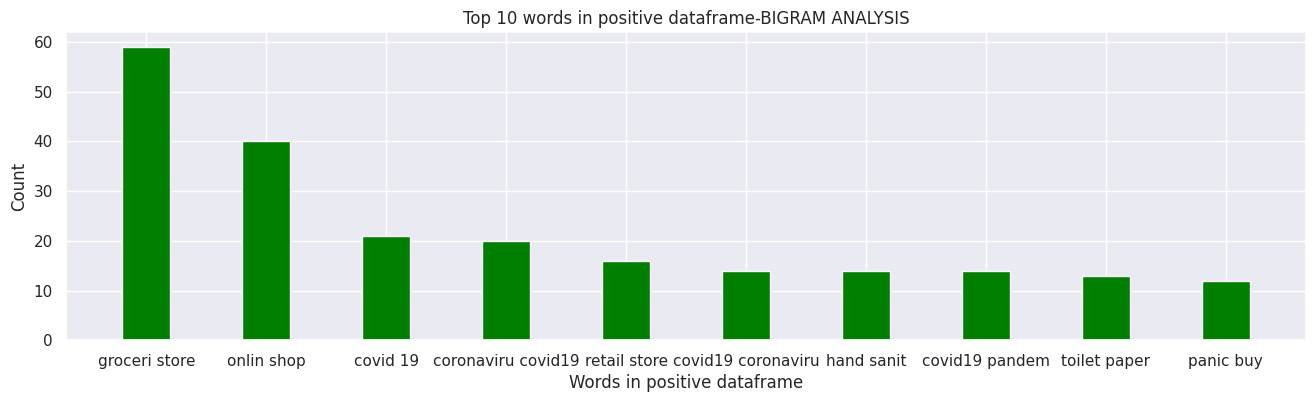

In [128]:
pd1bi=df_positive2[0][:10]
pd2bi=df_positive2[1][:10]

ned1bi=df_negative2[0][:10]
ned2bi=df_negative2[1][:10]


plt.figure(1,figsize=(16,4))

plt.bar(pd1bi,pd2bi, color ='green',
        width = 0.4)

plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-BIGRAM ANALYSIS")

plt.savefig("positive-bigram.png")
plt.show()

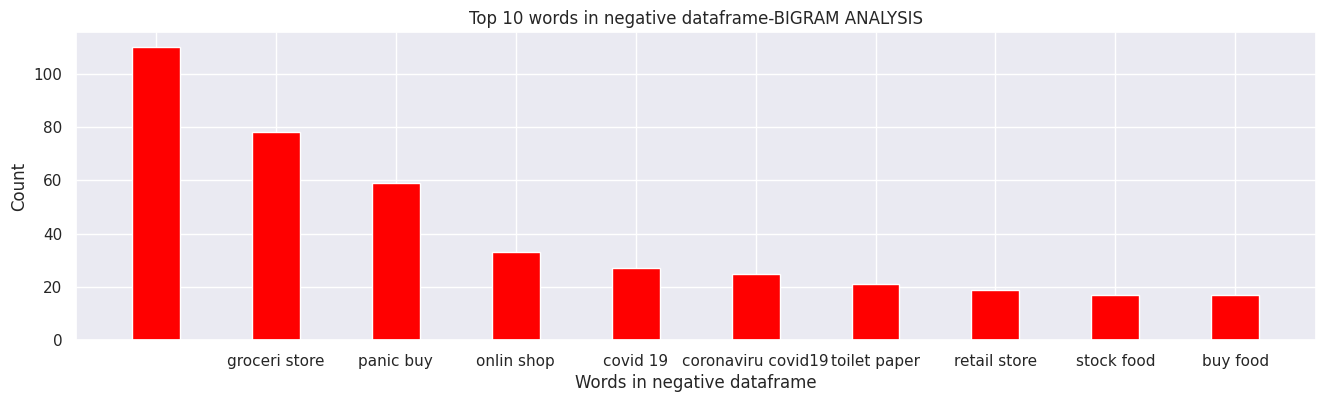

In [129]:
plt.figure(1,figsize=(16,4))

plt.bar(ned1bi,ned2bi, color ='red',
        width = 0.4)

plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-BIGRAM ANALYSIS")

plt.savefig("negative-bigram.png")
plt.show()

**NGram- Trigrams**

In [130]:
positiveValues3=defaultdict(int)
negativeValues3=defaultdict(int)

In [131]:
#get the count of every word in the dataframe where sentiment="positive"
for textt in df[df.Sentiment=="Positive"].text:
  for word in generate_N_grams(textt,3):
    positiveValues3[word]+=1

#get the count of every word in the dataframe where sentiment="negative"
for textt in df[df.Sentiment=="Negative"].text:
  for word in generate_N_grams(textt,3):
    negativeValues3[word]+=1


Sentence after removing stopwords: ['advic', 'talk', 'neighbour', 'famili', 'exchang', 'phone', 'number', 'creat', 'contact', 'list', 'phone', 'number', 'neighbour', 'school', 'employ', 'chemist', 'gp', 'set', 'onlin', 'shop', 'account', 'poss', 'adequ', 'suppli', 'regular', 'med', 'order']
Sentence after removing stopwords: ['coronaviru', 'australia', 'woolworth', 'give', 'elderli', 'disabl', 'dedic', 'shop', 'hour', 'amid', 'covid19', 'outbreak', 'httpstcobinca9vp8p']
Sentence after removing stopwords: ['food', 'stock', 'one', 'empti', 'pleas', 'dont', 'panic', 'enough', 'food', 'everyon', 'take', 'need', 'stay', 'calm', 'stay', 'safe', 'covid19fr', 'covid19', 'covid19', 'coronaviru', 'confin', 'confinementot', 'confinementgener', 'httpstcozrlg0z520j']
Sentence after removing stopwords: ['news', 'regionâ\x92', 'first', 'confirm', 'covid19', 'case', 'came', 'sullivan', 'counti', 'last', 'week', 'peopl', 'flock', 'area', 'store', 'purchas', 'clean', 'suppli', 'hand', 'sanit', 'food', '

In [132]:
#focus on more frequently occuring words for every sentiment=>
#sort in DO wrt 2nd column in each of positiveValues and negativeValues


df_positive3=pd.DataFrame(sorted(positiveValues3.items(),key=lambda x:x[1],reverse=True))
df_negative3=pd.DataFrame(sorted(negativeValues3.items(),key=lambda x:x[1],reverse=True))

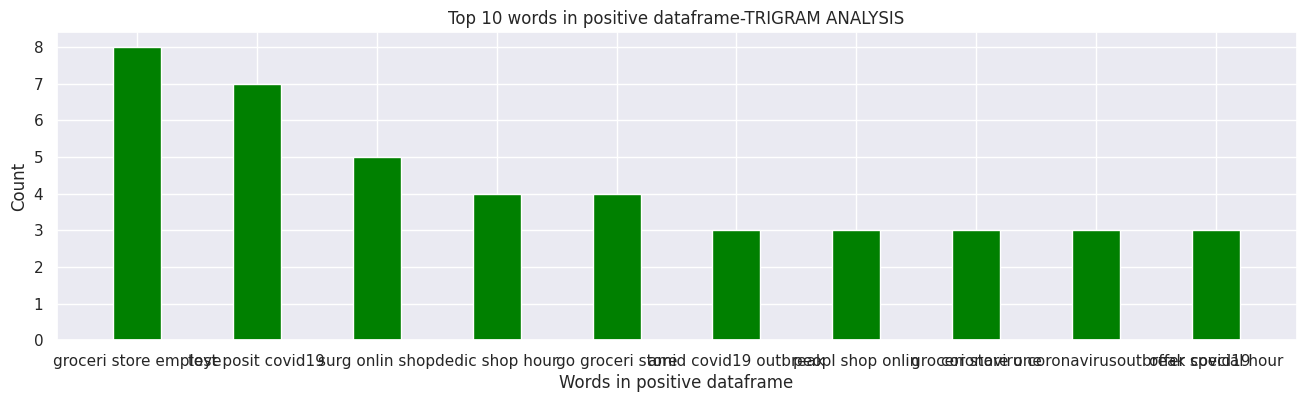

In [133]:
pd1tri=df_positive3[0][:10]
pd2tri=df_positive3[1][:10]

ned1tri=df_negative3[0][:10]
ned2tri=df_negative3[1][:10]


plt.figure(1,figsize=(16,4))

plt.bar(pd1tri,pd2tri, color ='green',
        width = 0.4)

plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in positive dataframe-TRIGRAM ANALYSIS")

plt.savefig("positive-trigram.png")
plt.show()


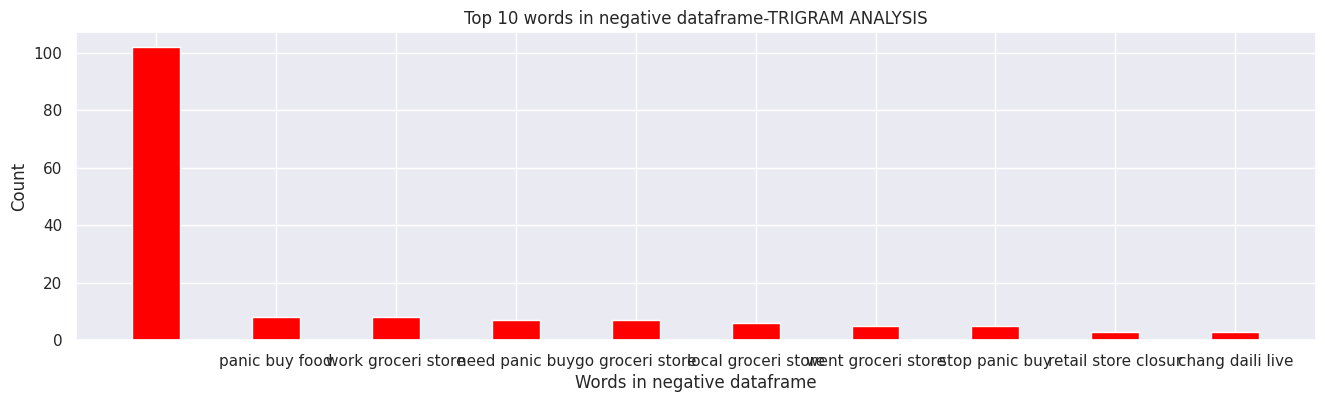

In [134]:
plt.figure(1,figsize=(16,4))

plt.bar(ned1tri,ned2tri, color ='red',
        width = 0.4)

plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-TRIGRAM ANALYSIS")

plt.savefig("negative-trigram.png")
plt.show()

# **Task 5 –Text Classification / Prediction**

**Steps in Modelling process using sklearn package**

* Split the data into training and test sets (80% train, 20% test)
*   Extract features from the training data using TfidfVectorizer.


*   Transform the test data into the same feature vector as the training data.
*   Train the classifier


*   Evaluate the classifier








In [135]:
df.head()

,OriginalTweet,Sentiment,text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Negative,menyrbi philgahan chrisitv httpstcoifz9fan2pa ...
1,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,Positive,food stock one empti pleas dont panic enough f...
4,"Me, ready to go at supermarket during the #COV...",Negative,readi go supermarket covid19 outbreak im paran...


In [136]:
df['Sentiment'] = df.Sentiment.map({'Positive':1, 'Negative':0})


In [137]:
docs = list(df['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [138]:
X = docs
y = df['Sentiment']
print(X.shape, y.shape)

(1000, 4836) (1000,)


In [139]:
import plotly.graph_objects as go
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [197]:
#Train-Test Split
#split the data into 80% training and 20% testing
SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 4836) (800,)
(200, 4836) (200,)


**Decision Tree Classifier**

In [194]:
from sklearn.tree import DecisionTreeClassifier
SEED=123
dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 401 ms, sys: 402 µs, total: 401 ms
Wall time: 402 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7


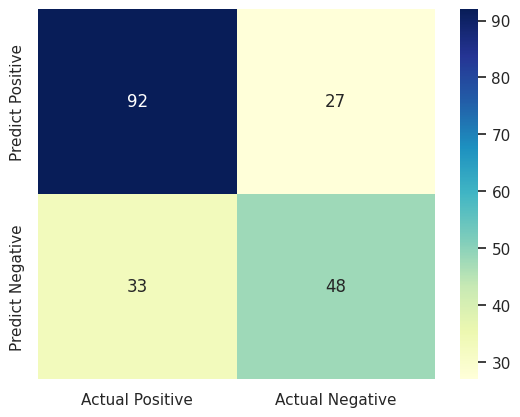

In [195]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [196]:
print(classification_report(y_test, y_pred_test, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.74      0.77      0.75       119
    Positive       0.64      0.59      0.62        81

    accuracy                           0.70       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.70      0.70      0.70       200



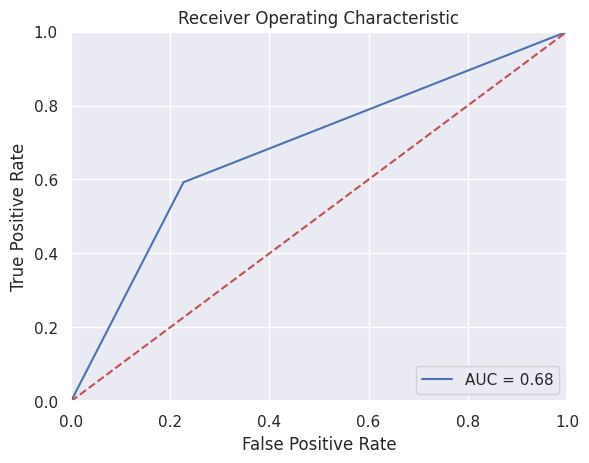

In [180]:
import sklearn.metrics as metrics
probs = dt.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Support Vector Machines Classifier**

In [207]:
from sklearn.svm import LinearSVC
svc =  LinearSVC(class_weight='balanced')
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 29.9 ms, sys: 0 ns, total: 29.9 ms
Wall time: 36.7 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.75


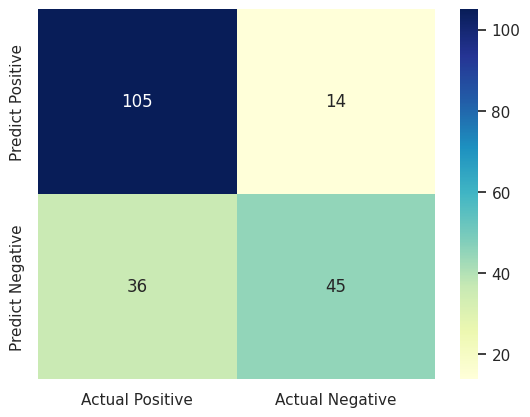

In [208]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [209]:
print(classification_report(y_test, y_pred_test, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.74      0.88      0.81       119
    Positive       0.76      0.56      0.64        81

    accuracy                           0.75       200
   macro avg       0.75      0.72      0.73       200
weighted avg       0.75      0.75      0.74       200



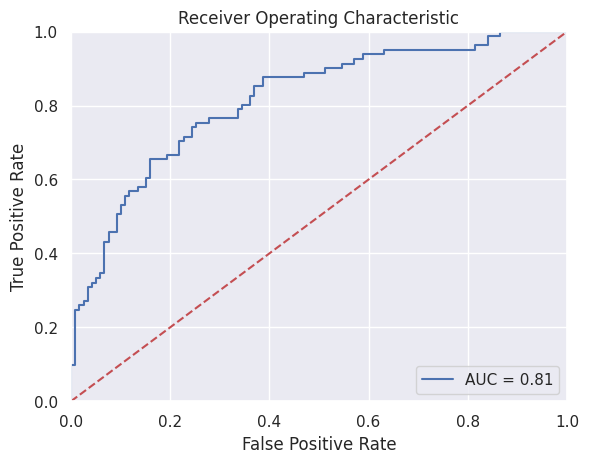

In [210]:
probs = svc._predict_proba_lr(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Inference:**
From the evaluation metrics provided, it is evident that the SVM classifier outperforms the Decision Tree Classifier in terms of accuracy, precision, recall, F1-score, and AUC. The Decision Tree Classifier has an accuracy of 0.70, which means it correctly predicts the target variable 70% of the time. Similarly, it has a precision of 0.70, indicating that 70% of the positive predictions made by the classifier are true positives. The recall for the Decision Tree Classifier is 0.68, meaning that 68% of the actual positive instances are correctly identified. The F1-score, which combines precision and recall, is 0.70.

On the other hand, the SVM classifier has a higher accuracy of 0.75, indicating that it has an overall higher percentage of correct predictions compared to the Decision Tree Classifier. It also has a precision of 0.75, meaning 75% of the positive predictions made by the SVM classifier are true positives. The recall for the SVM classifier is 0.72, indicating that it correctly identifies 72% of the actual positive instances. The F1-score for the SVM classifier is 0.74, which is higher than that of the Decision Tree Classifier.

When considering the AUC score, which measures the overall performance of a classifier by taking into account the trade-off between true positive rate and false positive rate, the SVM classifier also outperforms the Decision Tree Classifier. The Decision Tree Classifier has an AUC of 0.68, while the SVM classifier has a higher AUC of 0.81. A higher AUC value typically suggests a better-performing model.

Based on these evaluation metrics, it can be inferred that the SVM classifier is more effective in predicting and classifying the data compared to the Decision Tree Classifier.